In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using plaidml.keras.backend backend.


In [2]:
# resizing all images to 224 x 224
IMAGE_SIZE = [224, 224]

In [3]:
train_path = 'Datasets/Train'
valid_path = 'Datasets/Test'

In [4]:
#adding the preprocessing layer to the front of the VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


In [5]:
#don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [6]:
#useful for getting number of classes
folders = glob('Datasets/Train/*')

In [7]:
#layers that are going to be trained
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation = 'softmax')(x)

In [8]:
#creating a model
model = Model(inputs = vgg.input, outputs = prediction)

In [9]:
#model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
#choosing cost and optimization
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
training_set = train_datagen.flow_from_directory(
    'Datasets/Train',
    target_size=(224,224),
    batch_size=32,
    class_mode = 'categorical'
)

test_set = test_datagen.flow_from_directory(
    'Datasets/Test',
    target_size=(224,224),
    batch_size=32,
    class_mode = 'categorical'
)

Found 1052 images belonging to 2 classes.
Found 544 images belonging to 2 classes.


In [13]:
#fitting the model
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/5
33/33 [==============================] - 42s 1s/step - loss: 1.6886 - acc: 0.9053 - val_loss: 0.6043 - val_acc: 0.9246
Epoch 2/5
33/33 [==============================] - 42s 1s/step - loss: 0.0516 - acc: 0.9848 - val_loss: 0.2414 - val_acc: 0.9246
Epoch 3/5
33/33 [==============================] - 42s 1s/step - loss: 0.0040 - acc: 0.9981 - val_loss: 0.0165 - val_acc: 0.9945
Epoch 4/5
33/33 [==============================] - 44s 1s/step - loss: 0.0099 - acc: 0.9981 - val_loss: 0.0424 - val_acc: 0.9908
Epoch 5/5
33/33 [==============================] - 47s 1s/step - loss: 0.0052 - acc: 0.9981 - val_loss: 0.0347 - val_acc: 0.9908


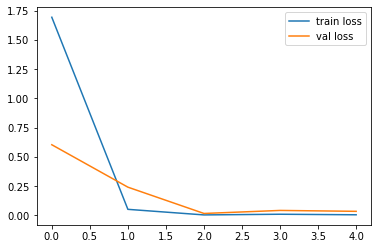

<Figure size 432x288 with 0 Axes>

In [14]:
#displaying the loss and accuracies
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_Loss')

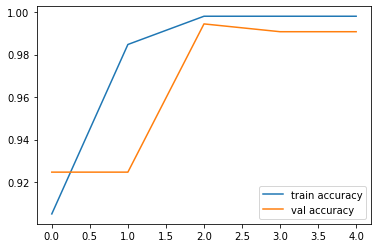

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(r.history['acc'], label = 'train accuracy')
plt.plot(r.history['val_acc'], label = 'val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
model.save('facefeatures_new_model.h5')